In [ ]:
# seems like the figures below can only be shown correctly in google colab but not in VS Code (at least not for MacOS)

# note covered below:

# 1) Exponential smoothing, particularly with appropriate trend and seasonal components, can capture trends without over-projecting future increases,
#    which seems important when Sarima is less conservative than needed.
#    long-term forecasts (many months ahead), ZARIMA can produce unrealistic, exponentially increasing forecasts,
#    while exponential smoothing remains stable, making it preferable for such scenarios
#    Unlike ARIMA/SARIMA, exponential smoothing does not have formal tests for specifying trend and seasonality,
#    so visual inspection and empirical judgment are typically used.

# 2) prophet, particularly with make_holidays_df

# 3) sklearn's TimeSeriesSplit

# Data stationarity assumptions

ARIMA/SARIMAX assumes the time series to be stationary both in mean and variance.

In other words, the series should have constant mean and variance over time.

- Log transformation to stabilize variance.
- Differencing to stabilize mean.

## Load data

In [1]:
path = './AirPassengers.parquet'

In [2]:
import pandas as pd
df = pd.read_parquet(path).asfreq("ME")
df.columns = ['values']

df

,values
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390


## Achieve stationarity

| **Property**             | **Issue**           | **Fix**               | **Test** |
| ------------------------ | ------------------- | --------------------- | -------- |
| Stationarity in variance | Changing volatility | Log transform / GARCH | ARCH     |
| Stationarity in mean     | Trend / Drift       | Differencing          | ADF      |


### Variance

<Axes: >

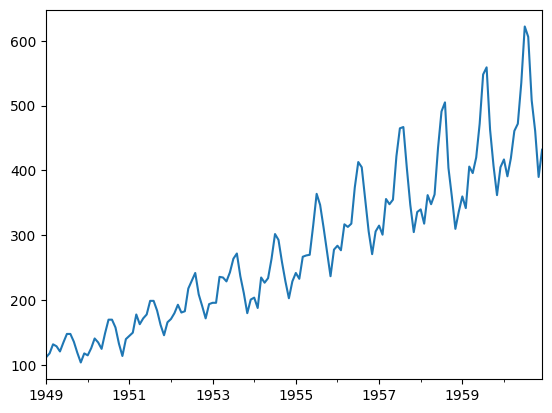

In [3]:
df['values'].plot()

In [4]:
import numpy as np
df['values_log'] = np.log(df['values'])
#A logarithmic transformation helps stabilize variance,
#making it roughly constant despite a growing trend and seasonal amplitude in time series data.
df

,values,values_log
1949-01-31,112,4.718499
1949-02-28,118,4.770685
1949-03-31,132,4.882802
1949-04-30,129,4.859812
1949-05-31,121,4.795791
...,...,...
1960-08-31,606,6.406880
1960-09-30,508,6.230481
1960-10-31,461,6.133398
1960-11-30,390,5.966147


In [6]:
import plotly.io as pio
pio.templates.default = "plotly_dark"
pd.options.plotting.backend = "plotly"
pio.templates["plotly_dark"].layout.update(width=1000, height=500, showlegend=True, autosize=False)

Layout({
    'annotationdefaults': {'arrowcolor': '#f2f5fa', 'arrowhead': 0, 'arrowwidth': 1},
    'autosize': False,
    'autotypenumbers': 'strict',
    'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
    'colorscale': {'diverging': [[0, '#8e0152'], [0.1, '#c51b7d'], [0.2,
                                 '#de77ae'], [0.3, '#f1b6da'], [0.4, '#fde0ef'],
                                 [0.5, '#f7f7f7'], [0.6, '#e6f5d0'], [0.7,
                                 '#b8e186'], [0.8, '#7fbc41'], [0.9, '#4d9221'],
                                 [1, '#276419']],
                   'sequential': [[0.0, '#0d0887'], [0.1111111111111111,
                                  '#46039f'], [0.2222222222222222, '#7201a8'],
                                  [0.3333333333333333, '#9c179e'],
                                  [0.4444444444444444, '#bd3786'],
                                  [0.5555555555555556, '#d8576b'],
                                  [0.6666666666666666, '#ed7953'],
    

In [7]:
fig = df.plot(facet_col='variable')
fig.update_yaxes(matches=None)

### Mean

In [8]:
from statsmodels.tsa.stattools import adfuller
adfuller(df['values_log'])

(np.float64(-1.7170170891069683),
 np.float64(0.4223667747703874),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(-445.3990312497209))

In [9]:
df['values_log_diff'] = df['values_log'].diff()
df.dropna(inplace=True)
df

,values,values_log,values_log_diff
1949-02-28,118,4.770685,0.052186
1949-03-31,132,4.882802,0.112117
1949-04-30,129,4.859812,-0.022990
1949-05-31,121,4.795791,-0.064022
1949-06-30,135,4.905275,0.109484
...,...,...,...
1960-08-31,606,6.406880,-0.026060
1960-09-30,508,6.230481,-0.176399
1960-10-31,461,6.133398,-0.097083
1960-11-30,390,5.966147,-0.167251


In [10]:
adfuller(df['values_log_diff'])
#A p-value above 0.05 indicates the mean is still non-stationary. Differencing addresses non-stationarity of the mean.

(np.float64(-2.717130598388114),
 np.float64(0.07112054815086184),
 14,
 128,
 {'1%': np.float64(-3.4825006939887997),
  '5%': np.float64(-2.884397984161377),
  '10%': np.float64(-2.578960197753906)},
 np.float64(-440.35846985568105))

In [11]:
fig = df.plot(facet_col='variable')
fig.update_yaxes(matches=None)
fig.update_layout()

## Modelling

### Model fit

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['values_log'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()

### Forecast

In [13]:
forecast = model_fit.forecast(steps=48)

In [14]:
df_forecast = pd.DataFrame({
    'historical': df['values'],
    'forecast': np.exp(forecast)
})
#The logarithmic transformation is not in the original scale of the data; to compare forecasts to real values,
#you must apply the exponential function to bring predictions back to the original scale.
df_forecast

,historical,forecast
1949-02-28,118.0,NaN
1949-03-31,132.0,NaN
1949-04-30,129.0,NaN
1949-05-31,121.0,NaN
1949-06-30,135.0,NaN
...,...,...
1964-08-31,NaN,896.139888
1964-09-30,NaN,749.993268
1964-10-31,NaN,667.947941
1964-11-30,NaN,577.572384


In [15]:
df_forecast.plot()